## 1. Učitavanje potrebnih paketa

In [1]:
# Standardne biblioteke
import sys
sys.path.append('../../')

import itertools

# Analiza podataka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL i stable_baselines3 za strojno učenje i trgovanje
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primorl import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Konfiguracijski fajlovi i pomoćne funkcije iz FinRL
from finrl.config import INDICATORS, FUNDAMENTAL_INDICATORS
from finrl.main import check_and_make_directories

# Omogućavanje prikaza grafikona unutar Jupyter bilježnice
%matplotlib inline

TRAINED_MODEL_DIR = 'trained_models_primorl'
RESULTS_DIR = 'results_primorl'
DATA_DIR = 'data_primorl'

# Provjera i kreiranje direktorija
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Dohvaćanje podataka

Imamo klasu nazvanu YahooDownloader koja koristi yfinance za dohvaćanje podataka s Yahoo Finance.

U YahooDownloader-u FinRL-a, modificirali smo okvir podataka u oblik koji je pogodan za daljnju obradu podataka. Koristimo prilagođenu zatvarajuću cijenu umjesto zatvarajuće cijene i dodajemo stupac koji predstavlja dan u tjednu (0-4 što odgovara ponedjeljku-petku).

In [2]:
# Intervali za trening i trgovanje
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2023-12-31'
TRADE_START_DATE = '2024-01-01'
TRADE_END_DATE = '2024-07-31'

Učitavamo podatke iz CSV datoteke koja sadrži generirane značajke od strane GPT-4 modela.

In [3]:
gpt_predictions = pd.read_csv('data/MSFT_data.csv')

# Preimenovanje stupca 'Date' u 'date'
gpt_predictions = gpt_predictions.rename(columns={'Date': 'date'})

gpt_predictions.head()

,date,Adj Close Price,Returns,Bin Label,News Relevance,Sentiment,Price Impact Potential,Trend Direction,Earnings Impact,Investor Confidence,Risk Profile Change,Prompt
0,2021-09-02,293.587524,-0.002253,D1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...
1,2021-09-03,293.577789,-0.000033,D1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...
2,2021-09-07,292.641907,-0.003188,D1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...
3,2021-09-08,292.671112,0.000100,U1,1,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...
4,2021-09-09,289.785461,-0.009860,D1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...


In [4]:
# Preuzimamo sve podatke
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ['MSFT']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (731, 8)


In [5]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2021-09-01,302.869995,305.190002,301.489990,294.250458,18983800,MSFT,2
1,2021-09-02,302.200012,303.359985,300.179993,293.587494,16285600,MSFT,3
2,2021-09-03,300.989990,302.600006,300.260010,293.577789,14747900,MSFT,4
3,2021-09-07,301.010010,301.089996,298.200012,292.641815,17180400,MSFT,1
4,2021-09-08,299.779999,300.609985,297.470001,292.671143,15046800,MSFT,2


## 3. Procesiranje podataka

Koristimo definiranu klasu FeatureEngineer pomoću koje radimo procesiranje podataka i dodavanje tehničkih indikatora.

Opcija use_vix uključuje VIX indeks, poznat kao "indeks straha", koji predstavlja očekivanu volatilnost tržišta dionica temeljenu na opcijama S&P 500 indeksa. VIX pomaže modelu da razumije tržišnu nesigurnost, s višim vrijednostima koje ukazuju na veću nesigurnost.

Opcija use_turbulence uključuje indeks turbulencije, koji mjeri neobične tržišne fluktuacije i služi kao pokazatelj rizika i tržišnih šokova. Koristan je za identifikaciju perioda visoke volatilnosti, pomažući modelu da se prilagodi financijskim krizama.

Inače dosta zgodna klasa koja sadrži korisne metode za obradu financijskih podataka i može se primjeniti u brojne druge svrhe.

In [6]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (730, 8)
Successfully added vix


In [7]:
# Stvara listu jedinstvenih oznaka dionica (tickers) iz stupca 'tic' DataFrame-a 'processed'.
list_ticker = processed["tic"].unique().tolist()

# Stvara listu datuma između najranijeg i najkasnijeg datuma u DataFrame-u 'processed', pretvara ih u stringove.
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))

# Stvara kombinacije svih datuma i oznaka dionica koristeći kartezijev produkt.
combination = list(itertools.product(list_date,list_ticker))

# Stvara novi DataFrame 'processed_full' s kolonama "date" i "tic", koji sadrži sve kombinacije datuma i oznaka dionica.
# Spaja taj DataFrame s originalnim DataFrame-om 'processed' na temelju kolona "date" i "tic", koristeći 'left' spajanje.
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")

# Filtrira 'processed_full' DataFrame da sadrži samo one retke čiji su datumi prisutni u originalnom DataFrame-u 'processed'.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sortira 'processed_full' DataFrame po datumu i oznaci dionica.
processed_full = processed_full.sort_values(['date','tic'])

# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [8]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2021-09-01,MSFT,302.869995,305.190002,301.489990,294.250458,18983800.0,2.0,0.000000,294.856548,292.981403,0.000000,-66.666667,100.0,294.250458,294.250458,16.110001
1,2021-09-02,MSFT,302.200012,303.359985,300.179993,293.587494,16285600.0,3.0,-0.014874,294.856548,292.981403,0.000000,-66.666667,100.0,293.918976,293.918976,16.410000
2,2021-09-03,MSFT,300.989990,302.600006,300.260010,293.577789,14747900.0,4.0,-0.019254,294.576436,293.034058,0.000000,-62.470432,100.0,293.805247,293.805247,16.410000
6,2021-09-07,MSFT,301.010010,301.089996,298.200012,292.641815,17180400.0,1.0,-0.054567,294.837288,292.191490,0.000000,-128.679397,100.0,293.514389,293.514389,18.139999
7,2021-09-08,MSFT,299.779999,300.609985,297.470001,292.671143,15046800.0,2.0,-0.071439,294.717380,291.974099,1.901877,-95.349085,100.0,293.345740,293.345740,17.959999


Radimo spajanje ovih preuzetih podataka s podacima iz CSV datoteke koja sadrži generirane značajke od strane PrimoGPT modela.

In [9]:
# Spajanje prema datumu
processed_full = processed_full.merge(gpt_predictions, on='date', how='left')
processed_full = processed_full.fillna(0)

# Uklanjanje nepotrebnih stupaca
columns_to_drop = ['Adj Close Price', 'Returns', 'Bin Label', 'Prompt']
processed_full = processed_full.drop(columns=columns_to_drop)

# Ručno preimenovanje specifičnih stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Preimenovanje stupaca
processed_full = processed_full.rename(columns=column_mapping)

In [10]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,close_30_sma,close_60_sma,vix,news_relevance,sentiment,price_impact_potential,trend_direction,earnings_impact,investor_confidence,risk_profile_change
0,2021-09-01,MSFT,302.869995,305.190002,301.489990,294.250458,18983800.0,2.0,0.000000,294.856548,...,294.250458,294.250458,16.110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-02,MSFT,302.200012,303.359985,300.179993,293.587494,16285600.0,3.0,-0.014874,294.856548,...,293.918976,293.918976,16.410000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-03,MSFT,300.989990,302.600006,300.260010,293.577789,14747900.0,4.0,-0.019254,294.576436,...,293.805247,293.805247,16.410000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-07,MSFT,301.010010,301.089996,298.200012,292.641815,17180400.0,1.0,-0.054567,294.837288,...,293.514389,293.514389,18.139999,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-08,MSFT,299.779999,300.609985,297.470001,292.671143,15046800.0,2.0,-0.071439,294.717380,...,293.345740,293.345740,17.959999,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Pripremamo trening i trade set sukladno definiranim datumima
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

586
144


In [12]:
# Spremamo podatke
train.to_csv(DATA_DIR + '/train_data.csv')
trade.to_csv(DATA_DIR + '/trade_data.csv')

## 4. Priprema environmenta

stock_dimension predstavlja broj jedinstvenih dionica u skupu podataka. Ova vrijednost se koristi za određivanje koliko različitih dionica model može trgovati.

state_space označava ukupnu veličinu prostora stanja koji model koristi za donošenje odluka. Prostor stanja uključuje trenutne podatke o dionicama (kao što su cijene i tehnički indikatori) i informacije o trenutnom portfelju (kao što su broj dionica koje posjeduje). Veličina prostora stanja određena je formulom koja uzima u obzir broj dionica i broj tehničkih indikatora.

In [13]:
# Izračunavamo dimenziju (broj jedinstvenih dionica) iz DataFrame-a 'train'.
stock_dimension = len(train.tic.unique())

# Izračunavamo veličinu stanja na temelju dimenzije i broja tehničkih indikatora.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 18


In [14]:
# Stvara liste troškova kupnje i prodaje za svaku dionicu.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Inicijalizira broj dionica za svaku dionicu na 0.
num_stock_shares = [0] * stock_dimension

e_train_gym je instanca klase StockTradingEnv, koja predstavlja okruženje za trgovanje. Ovo okruženje koristi podatke i parametre definirane za simulaciju tržišta dionica. Model uči kako trgovati unutar ovog okruženja, pokušavajući maksimizirati ukupnu nagradu (profit) kroz seriju trgovačkih odluka.

env_train dobiva se pozivom metode get_sb_env() na instanci e_train_gym. Ova metoda vraća okruženje kompatibilno s bibliotekom Stable Baselines 3, koja se koristi za implementaciju algoritama pojačanog učenja. Drugi povratni element, koji se ovdje ignorira (_), može se koristiti za dodatne informacije ili funkcionalnosti koje pruža okruženje.

In [15]:
# Definira argumente za okruženje trgovanja.
env_kwargs = {
    "hmax": 1000,  # Maksimalni broj dionica koje se mogu kupiti ili prodati u jednoj transakciji.
    "initial_amount": 100000,  # Početni iznos kapitala.
    "num_stock_shares": num_stock_shares,  # Početni broj dionica svake dionice u portfelju, inicijalno postavljen na 0.
    "buy_cost_pct": buy_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "sell_cost_pct": sell_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "state_space": state_space,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "stock_dim": stock_dimension,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "tech_indicator_list": INDICATORS,  # Lista tehničkih indikatora koji će se koristiti za analizu stanja tržišta.
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,  # Lista fundamentalnih indikatora koji će se koristiti za analizu stanja tržišta.
    "action_space": stock_dimension,  # Veličina prostora akcija, odnosno, broj različitih akcija koje model može izvršiti.
    "reward_scaling": 1e-2,  # Faktor skaliranja za nagradu, koristi se za prilagodbu veličine nagrade kako bi se olakšalo učenje.
    "verbose": 0
}

# Kreira okruženje za treniranje.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Dohvaća okruženje pogodno za Stable Baselines i neiskorišteni objekt.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Trening DRL agenata

Ovdje su algoritmi dubokog pojačanog učenja (DRL) iz biblioteke Stable Baselines 3. Radi se o biblioteci koja je implementirala popularne DRL algoritme koristeći PyTorch.

Kao zamjena mogu se koristiti biblioteke ElegantRL i Ray RLlib.

### Trening 5 različitih DRL agenata (A2C, DDPG, PPO, TD3, SAC)

In [16]:
# Postavljanje odgovarajućih vrijednosti na 'True' za algoritme koje želite koristiti
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

#### Agent 1: A2C

In [17]:
# Ponovno se kreira instanca DRL agenta s predanim okruženjem (nije potrebno ponovno raditi, ali zbog lakših uputa neka stoji)
agent = DRLAgent(env = env_train)
# Dohvaća model A2C pomoću metode get_model
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Postavljanje loggera za praćenje i zapisivanje informacija tijekom treniranja
  tmp_path = RESULTS_DIR + '/a2c'
  # Konfigurira novi logger koji će ispisivati informacije na standardni izlaz, zapisivati u CSV datoteku i TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Postavlja novi logger za model A2C.
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [18]:
# Trenira model A2C s definiranim ukupnim brojem vremenskih koraka, samo ako je if_using_a2c postavljen na True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

In [19]:
# Sprema trenirani model A2C u definirani direktorij, samo ako je if_using_a2c postavljen na True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [20]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [21]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [22]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [23]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
       "n_steps": 2048,
       "ent_coef": 0.01,
       "learning_rate": 0.00025,
       "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results_primorl/ppo


In [24]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000) if if_using_ppo else None

--------------------------------------
| time/              |               |
|    fps             | 1953          |
|    iterations      | 1             |
|    time_elapsed    | 1             |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | 0.00024252923 |
--------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1716         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.006923072  |
|    clip_fraction        | 0.0577       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -7.05        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.00254     |
|    n_updates            | 10           |
|   

In [25]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [26]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [27]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [28]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [29]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [30]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

In [31]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Priprema za backtest

In [32]:
# Po potrebi učitavamo sporemnjene podatke ako smo restrartali proces (nije potrebno)
train = pd.read_csv(DATA_DIR + '/train_data.csv')
trade = pd.read_csv(DATA_DIR + '/trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [33]:
# Po potrebi učitavamo sporemnjene podatke o treningu agenata ako smo restrartali proces (nije potrebno)
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trgovanje (podatci izvan trening seta)

Ovdje sada za trgovanje koristimo trade skup podataka koji nikad nije bio korišten za trening. Dodatno sličnim pristupom bi mogli i dotrenirati postojeći spremljeni model.

Brojni hiperparametri, na primjer, stopa učenja, ukupan broj uzoraka za trening – utječu na proces učenja i obično se određuju testiranjem nekih varijacija.

In [34]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 18


In [35]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2,
    "verbose": 1
}

Ovaj dio se odnosi se na korištenje dubokog pojačanog učenja (DRL) za simulaciju trgovanja u stvarnom vremenu koristeći prethodno trenirani model (u ovom slučaju, A2C). StockTradingEnv je okruženje koje simulira tržište dionica s obzirom na povijesne podatke, prag turbulencije (koji se koristi za određivanje volatilnosti tržišta), i 'VIX' kao pokazatelj rizika. Nakon inicijalizacije okruženja, koristi se metoda get_sb_env() za dohvaćanje okruženja i početne opservacije koje su kompatibilne sa Stable Baselines bibliotekom.

In [36]:
# Inicijalizacija okruženja za trgovanje s definiranim DataFrame-om 'trade', pragom turbulencije i pokazateljem rizika 'vix',
# zajedno s ostalim parametrima okruženja ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Dohvaćanje okruženja kompatibilnog sa Stable Baselines i početne opservacije.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Initialized environment with 1 stocks
Technical indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
Fundamental indicators: ['news_relevance', 'sentiment', 'price_impact_potential', 'trend_direction', 'earnings_impact', 'investor_confidence', 'risk_profile_change']
Initial amount: 100000
Initial stock shares: [0]

Resetting environment. Episode: 0
Initial state: [100000, 368.8540954589844, 0, 2.24423437018811, 375.4639584069578, 365.27965426394064, 55.33911168974989, -55.20172188071603, 13.649035894526168, 371.8722737630208, 356.41210123697914, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 368.85, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00


Zatim se DRL agent koristi za predviđanje akcija trgovanja i promjene u vrijednosti računa na temelju treniranog modela. To omogućuje evaluaciju performansi modela u scenariju izvan uzorka, pružajući uvid u to kako bi model mogao performirati u stvarnim trgovačkim uvjetima. Ako je odabrana upotreba A2C algoritma (kao što je indicirano varijablom if_using_a2c), provodi se predviđanje; u suprotnom, rezultat se postavlja na None.

In [37]:
# Korištenje DRL agenta za predviđanje koristeći trenirani model 'trained_a2c' i definirano okruženje trgovanja 'e_trade_gym'.
# Rezultati su dva DataFrame-a: 'df_account_value_a2c' s vrijednostima računa i 'df_actions_a2c' s akcijama koje su poduzete,
# ako je 'if_using_a2c' postavljen na True; inače se vraća (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

In [38]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [39]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)


Resetting environment. Episode: 1
Initial state: [100000, 368.8540954589844, 0, 2.24423437018811, 375.4639584069578, 365.27965426394064, 55.33911168974989, -55.20172188071603, 13.649035894526168, 371.8722737630208, 356.41210123697914, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 368.85, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00

Resetting environment. Episode: 2
Initial state: [100000, 368.8540954589844, 0, 2.24423437018811, 375.4639584069578, 365.27965426394064, 55.33911168974989, -55.20172188071603, 13.649035894526168, 371.8722737630208, 356.41210123697914, 2.0, -1.0, -2.0, -1.0, -1.0, -2.0, -1.0]
Number of stocks: 1
Initial holdings:
  Stock 0: Price: 368.85, Shares: 0
Initial cash: 100000.00
Initial total asset: 100000.00

Day: 0
Current state: [100000, 368.8540954589844, 0, 2.24423437018811, 375.4639584069578, 365.27965426394064, 55.33911168974989, -55.20172188071603, 13.649035894526168, 371.8722737630208,

In [40]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [41]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

## 8. B&H za usporedbu

In [42]:
df_aapl = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['MSFT']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (145, 8)


In [43]:
df_aapl = df_aapl[['date','close']]
fst_day = df_aapl['close'].iloc[0]
buy_and_hold = pd.merge(df_aapl['date'], df_aapl['close'].div(fst_day).mul(100000), 
                        how='outer', left_index=True, right_index=True).set_index('date')

## 10. Provodima backetinskg modela

In [44]:
# Postavljanje indeksa DataFrame-ova vrijednosti računa za svaku od DRL strategija, ako su odabrane.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Kreiranje praznog DataFrame-a za rezultate.
result = pd.DataFrame()

# Spajanje rezultata svih DRL strategija u jedan DataFrame, ako su odabrane.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Spajanje rezultata optimizacije srednje varijance i indeksa DJIA s glavnim rezultatima.
result = pd.merge(result, buy_and_hold, how='outer', left_index=True, right_index=True)

In [45]:
# Dodavanje imena stupaca na temelju odabranih strategija.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('B&H')
result.columns = col_name

In [46]:
# Prikazivanje rezultata
result.head()

,PPO,B&H
date,,
2024-01-02,100000.000000,100000.000000
2024-01-03,99948.174835,99927.200437
2024-01-04,99231.225677,99209.960509
2024-01-05,99180.016205,99158.730268
2024-01-08,101050.543091,101030.015775


### Ovdje plotiramo graf koji pokazuje ukupnu vrijednost portfolija korz vrijeme za pojedinu strategiju i benchmark

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

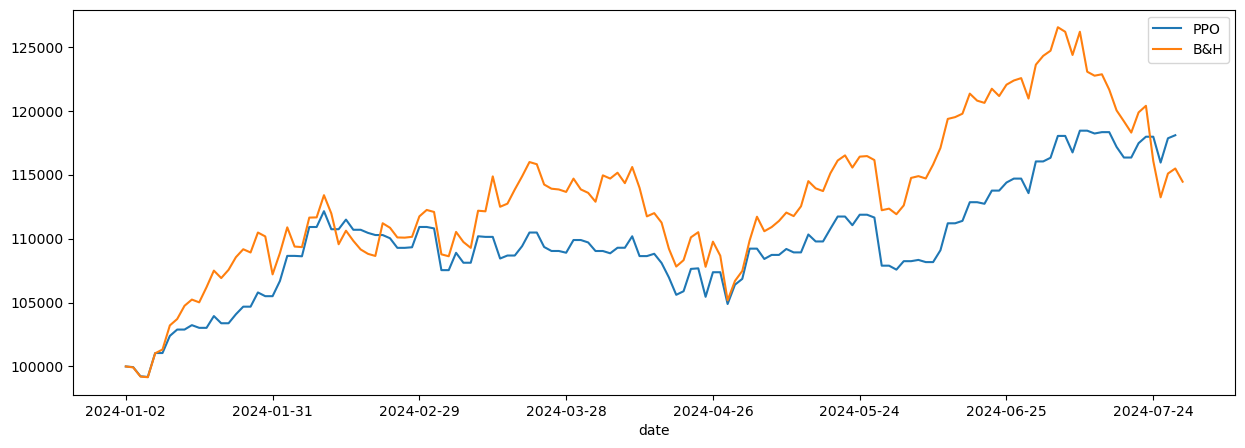

In [47]:
# Postavljanje veličine figure za grafikone i crtanje grafikona performansi strategija trgovanja.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

Na temelju vrijednosti portfolija računamo dnevne povrate 

In [48]:
from pyfolio import timeseries
import pandas as pd

# Lista strategija za koje želite generirati statistike
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "B&H"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Izračunavanje dnevnih povrata iz vrijednosti portfelja
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_60151/728507394.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()


In [49]:
result.head()

,PPO,B&H,PPO_returns,B&H_returns
date,,,,
2024-01-02,100000.000000,100000.000000,NaN,NaN
2024-01-03,99948.174835,99927.200437,-0.000518,-0.000728
2024-01-04,99231.225677,99209.960509,-0.007173,-0.007178
2024-01-05,99180.016205,99158.730268,-0.000516,-0.000516
2024-01-08,101050.543091,101030.015775,0.018860,0.018872


### Računamo povrate po odabranoj strategiji

In [50]:
# Pretpostavljamo da result DataFrame već sadrži vrijednosti portfelja za svaku strategiju
for strategy in strategies:
    # Provjerite postoji li strategija u DataFrame-u
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Izračunavanje statistika performansi za trenutnu strategiju
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Ispis statistika performansi
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategija {strategy} nije pronađena u rezultatima.\n")


Strategija A2C nije pronađena u rezultatima.

Strategija DDPG nije pronađena u rezultatima.

==============Strategy Stats (PPO)==============
Annual return          0.337665
Cumulative returns     0.180860
Annual volatility      0.143312
Sharpe ratio           2.102456
Calmar ratio           5.216865
Stability              0.606362
Max drawdown          -0.064726
Omega ratio            1.514071
Sortino ratio          3.193973
Skew                  -0.425276
Kurtosis               2.071335
Tail ratio             1.415657
Daily value at risk   -0.016860
dtype: float64


Strategija TD3 nije pronađena u rezultatima.

Strategija SAC nije pronađena u rezultatima.

==============Strategy Stats (B&H)==============
Annual return          0.266449
Cumulative returns     0.144515
Annual volatility      0.197844
Sharpe ratio           1.293093
Calmar ratio           2.534193
Stability              0.638731
Max drawdown          -0.105142
Omega ratio            1.236995
Sortino ratio          1.832

### Plotiramo komulativne povrate za pojedinu strategiju

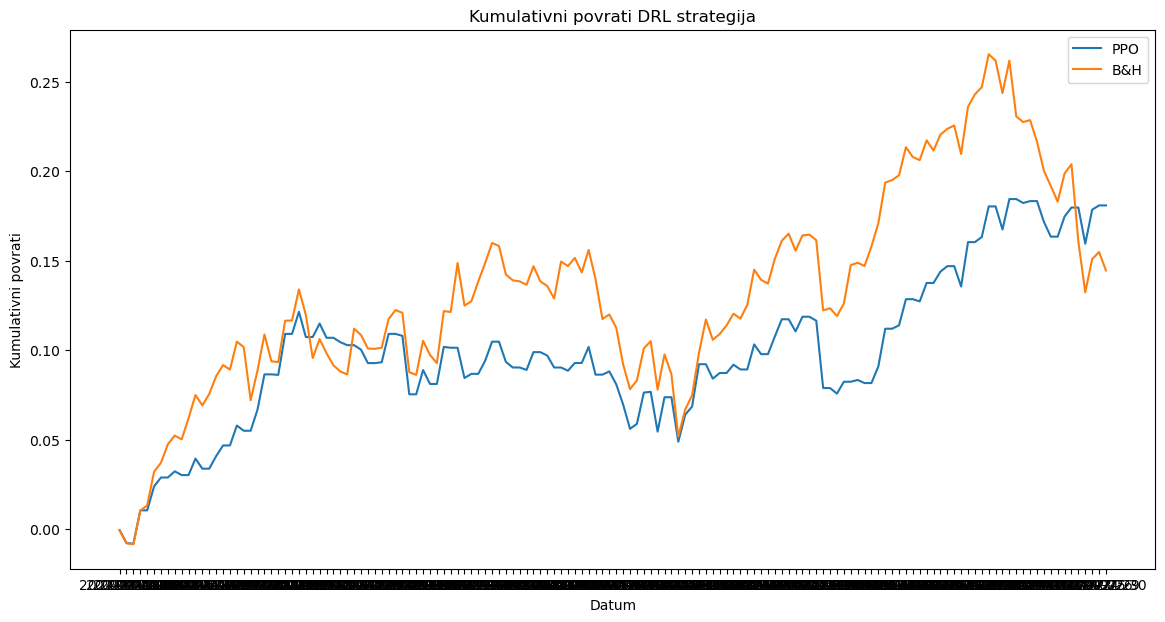

In [51]:
import matplotlib.pyplot as plt

# Postavljanje veličine figure za grafikon
plt.figure(figsize=(14, 7))

# Prolazak kroz svaku strategiju i crtanje njenih kumulativnih povrata
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju i pretvaranje u decimalni format ako je potrebno
        returns = result[f'{strategy}_returns'].dropna() + 1  # Dodaje 1 za korištenje cumprod()

        # Izračunavanje kumulativnih povrata
        cumulative_returns = returns.cumprod() - 1  # Oduzima 1 na kraju za prikazivanje pravog kumulativnog povrata

        # Plotiranje kumulativnih povrata
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Dodavanje naslova i legende na grafikon
plt.title('Kumulativni povrati DRL strategija')
plt.legend()

# Postavljanje oznaka za x i y osi
plt.xlabel('Datum')
plt.ylabel('Kumulativni povrati')

# Prikazivanje grafikona
plt.show()


### Spremamo rezultate u CSV
Potrebno promjeniti za svakog agenta

In [52]:
import pickle

# Za df_account_value_sac
with open('results/2. MSFT/msft_primorl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# Za df_actions_td3
with open('results/2. MSFT/msft_primorl_df_actions_ppo.pkl', 'wb') as f:
    pickle.dump(df_actions_ppo, f)

# Za buy_and_hold
with open('results/2. MSFT/msft_primorl_buy_and_hold.pkl', 'wb') as f:
    pickle.dump(buy_and_hold, f)